In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import xwrf
import xgcm
import metpy.calc as mpcalc
from metpy.units import units

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go

import warnings

In [2]:
projection = ccrs.Stereographic(
    central_latitude=90.0,          # North Pole
    central_longitude=-90.0,        # STAND_LON
    true_scale_latitude=60.0        # Usually TRUELAT2 for polar stereo
)


def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

In [3]:
# WAC00WG-01
wrf_ds = xr.open_dataset('../data/wrf_data/wrfout_d02_processed_23012000.nc')
wrf_ds

<xarray.Dataset> Size: 406MB
Dimensions:       (XTIME: 14, y: 426, x: 303, air_pressure: 5)
Coordinates:
  * XTIME         (XTIME) datetime64[ns] 112B 2023-01-20T06:00:00 ... 2023-01...
  * y             (y) float64 3kB -3.28e+06 -3.277e+06 ... -2.008e+06 -2.005e+06
  * x             (x) float64 2kB -2.247e+06 -2.244e+06 ... -1.341e+06
  * air_pressure  (air_pressure) int64 40B 50 100 250 500 850
    CLAT          (y, x) float32 516kB ...
    XLONG         (y, x) float32 516kB ...
    XLAT          (y, x) float32 516kB ...
Data variables:
    geopotential  (XTIME, y, x, air_pressure) float64 72MB ...
    u             (XTIME, y, x, air_pressure) float64 72MB ...
    v             (XTIME, y, x, air_pressure) float64 72MB ...
    ff            (XTIME, y, x, air_pressure) float64 72MB ...
    t             (XTIME, y, x, air_pressure) float64 72MB ...
    10u           (XTIME, y, x) float32 7MB ...
    10v           (XTIME, y, x) float32 7MB ...
    10ff          (XTIME, y, x) float32 7MB ...
    2t            (XTIME, y, x) float32 7MB ...
    msl           (XTIME, y, x) float32 7MB ...
    tp            (XTIME, y, x) float32 7MB ...
Attributes: (12/136)
    CDI:                             Climate Data Interface version 2.5.0 (ht...
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2023-01-20_03:00:00
    SIMULATION_START_DATE:           2023-01-20_00:00:00
    WEST-EAST_GRID_DIMENSION:        304
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Thu Jan 15 12:19:57 2026: cdo -L mergeti...
    CDO:                             Climate Data Operators version 2.5.0 (ht...

In [4]:
nan_counts = wrf_ds.isnull().sum(dim=['x','y','XTIME'])
print(nan_counts)

<xarray.Dataset> Size: 288B
Dimensions:       (air_pressure: 5)
Coordinates:
  * air_pressure  (air_pressure) int64 40B 50 100 250 500 850
Data variables:
    geopotential  (air_pressure) int64 40B 0 0 0 0 0
    u             (air_pressure) int64 40B 0 0 0 0 0
    v             (air_pressure) int64 40B 0 0 0 0 0
    ff            (air_pressure) int64 40B 0 0 0 0 0
    t             (air_pressure) int64 40B 0 0 0 0 0
    10u           int64 8B 0
    10v           int64 8B 0
    10ff          int64 8B 0
    2t            int64 8B 0
    msl           int64 8B 0
    tp            int64 8B 129078
Attributes: (12/136)
    CDI:                             Climate Data Interface version 2.5.0 (ht...
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2023-01-20_03:00:00
    SIMULATION_START_DATE:           2023-01-20_00:00:00
    WEST-EAST_GRID_DIMENSION:        304
    ...                          

In [5]:
print(wrf_ds.XTIME)

<xarray.DataArray 'XTIME' (XTIME: 14)> Size: 112B
array(['2023-01-20T06:00:00.000000000', '2023-01-20T12:00:00.000000000',
       '2023-01-20T18:00:00.000000000', '2023-01-21T00:00:00.000000000',
       '2023-01-21T06:00:00.000000000', '2023-01-21T12:00:00.000000000',
       '2023-01-21T18:00:00.000000000', '2023-01-22T00:00:00.000000000',
       '2023-01-22T06:00:00.000000000', '2023-01-22T12:00:00.000000000',
       '2023-01-22T18:00:00.000000000', '2023-01-23T00:00:00.000000000',
       '2023-01-23T06:00:00.000000000', '2023-01-23T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 112B 2023-01-20T06:00:00 ... 2023-01-23T1...
Attributes:
    standard_name:  time
    axis:           T


In [6]:
print(wrf_ds.y.values)
print(wrf_ds.x.values)

[-3279872.50256909 -3276872.50256909 -3273872.50256909 -3270872.50256909
 -3267872.50256909 -3264872.50256909 -3261872.50256909 -3258872.50256909
 -3255872.50256909 -3252872.50256909 -3249872.50256909 -3246872.50256909
 -3243872.50256909 -3240872.50256909 -3237872.50256909 -3234872.50256909
 -3231872.50256909 -3228872.50256909 -3225872.50256909 -3222872.50256909
 -3219872.50256909 -3216872.50256909 -3213872.50256909 -3210872.50256909
 -3207872.50256909 -3204872.50256909 -3201872.50256909 -3198872.50256909
 -3195872.50256909 -3192872.50256909 -3189872.50256909 -3186872.50256909
 -3183872.50256909 -3180872.50256909 -3177872.50256909 -3174872.50256909
 -3171872.50256909 -3168872.50256909 -3165872.50256909 -3162872.50256909
 -3159872.50256909 -3156872.50256909 -3153872.50256909 -3150872.50256909
 -3147872.50256909 -3144872.50256909 -3141872.50256909 -3138872.50256909
 -3135872.50256909 -3132872.50256909 -3129872.50256909 -3126872.50256909
 -3123872.50256909 -3120872.50256909 -3117872.50256

In [7]:
# CLIMATEX 
climatex_ds = xr.open_dataset('../data/prediction_data/bris-lam-inference-20230101T12-20230102T12.nc')
climatex_ds

<xarray.Dataset> Size: 135MB
Dimensions:       (values: 275716, initial_date: 4, lead_time: 5)
Coordinates:
  * initial_date  (initial_date) datetime64[ns] 32B 2023-01-01T12:00:00 ... 2...
  * lead_time     (lead_time) int32 20B 0 6 12 18 24
Dimensions without coordinates: values
Data variables:
    latitude      (values) float32 1MB ...
    longitude     (values) float32 1MB ...
    10u           (initial_date, lead_time, values) float32 22MB ...
    10v           (initial_date, lead_time, values) float32 22MB ...
    2t            (initial_date, lead_time, values) float32 22MB ...
    sp            (initial_date, lead_time, values) float32 22MB ...
    z_500         (initial_date, lead_time, values) float32 22MB ...
    z_850         (initial_date, lead_time, values) float32 22MB ...

In [8]:
print(climatex_ds.latitude.shape)
print(climatex_ds.longitude.shape)

(275716,)
(275716,)


/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


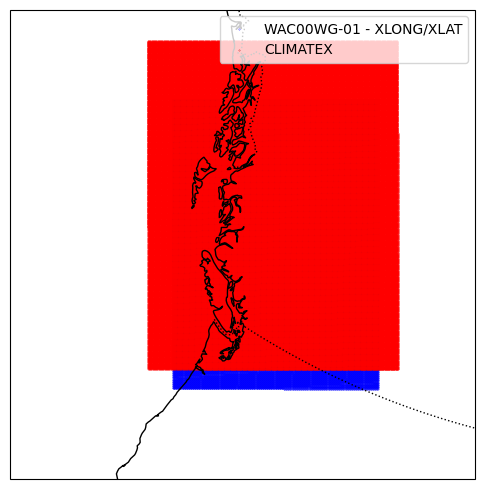

In [9]:
# Compare coordinates system
projection = ccrs.Stereographic(
    central_latitude=90.0,          # North Pole
    central_longitude=-90.0,        # STAND_LON
    true_scale_latitude=60.0        # Usually TRUELAT2 for polar stereo
)

fig, ax = plt.subplots(figsize=(6,12), subplot_kw={'projection': projection})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# WAC00WG-01 - XLONG/XLAT
ax.scatter(x=wrf_ds.XLONG.values.flatten(), y=wrf_ds.XLAT.values.flatten(), color='blue', s=0.05, label='WAC00WG-01 - XLONG/XLAT', transform=ccrs.PlateCarree())
ax.set_extent([wrf_ds.XLONG.min(), wrf_ds.XLONG.max(), wrf_ds.XLAT.min(), wrf_ds.XLAT.max()], crs=ccrs.PlateCarree())

# CLIMATEX
ax.scatter(x=climatex_ds.longitude, y=climatex_ds.latitude, c='red', s=0.05, label='CLIMATEX', transform=ccrs.PlateCarree())
ax.legend(loc='upper right')

# # WAC00WG-01 - X/Y
# X, Y = np.meshgrid(wrf_ds.x, wrf_ds.y)
# ax.scatter(X.flatten(), Y.flatten(), s=0.05, color='green', transform=projection, label='WAC00WG-01 - X/Y')

plt.show()

In [10]:
def get_rectangle(ax, lons, lats, label, edgecol):

    proj = ax.projection
    pts = proj.transform_points(    
        ccrs.PlateCarree(),
        lons,
        lats
    )
    x = pts[:, 0]
    y = pts[:, 1]

    # Bounding box in projected space
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=1.5,
        edgecolor=edgecol,
        facecolor='none',
        label=label,
    )

    return rect

In [11]:
stations_statistics = pd.read_csv('../data/eccc_data/stations_statistics.csv', index_col='STN_ID').drop(columns=['Unnamed: 0'])

/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


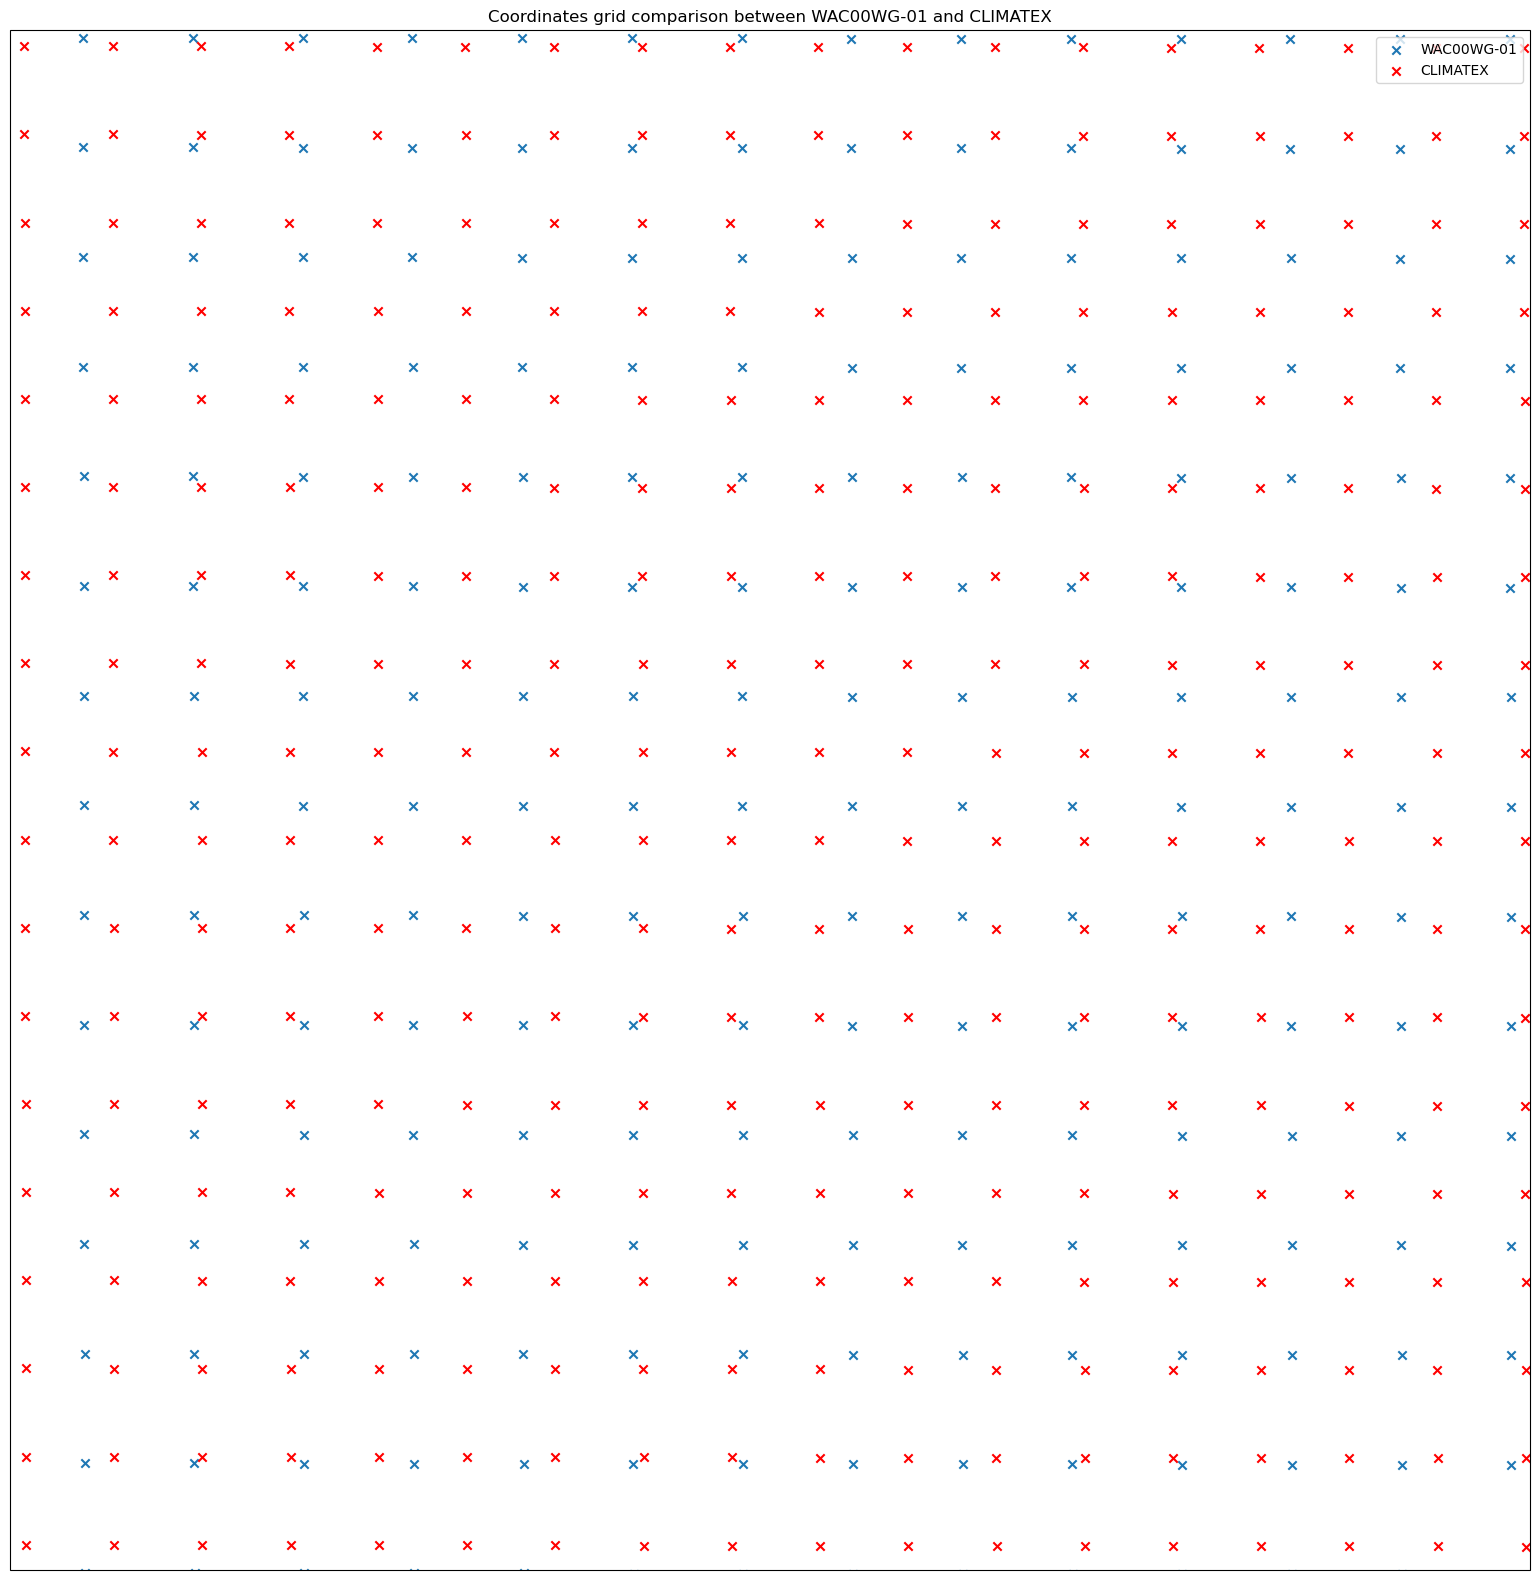

In [12]:
# Compare coordinates systems, zoom in
fig, ax = plt.subplots(figsize=(20,20), subplot_kw={'projection': projection})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Scatter plots
ax.scatter(
    wrf_ds.XLONG, wrf_ds.XLAT,
    marker='x', label='WAC00WG-01',
    transform=ccrs.PlateCarree()
)

ax.scatter(
    climatex_ds.longitude, climatex_ds.latitude,
    marker='x', c='r', label='CLIMATEX',
    transform=ccrs.PlateCarree()
)

# ---- ZOOM LOGIC ----
lon_min = wrf_ds.XLONG.min()
lon_max = wrf_ds.XLONG.max()
lat_min = wrf_ds.XLAT.min()
lat_max = wrf_ds.XLAT.max()

lon_c = 0.5 * (lon_min + lon_max)
lat_c = 0.5 * (lat_min + lat_max)

zoom_factor = 50

lon_half_width = (lon_max - lon_min) / (2 * zoom_factor)
lat_half_width = (lat_max - lat_min) / (2 * zoom_factor)

ax.set_extent(
    [
        lon_c - lon_half_width, lon_c + lon_half_width,
        lat_c - lat_half_width, lat_c + lat_half_width
    ],
    crs=ccrs.PlateCarree()
)

ax.legend(loc='upper right')
ax.set_title('Coordinates grid comparison between WAC00WG-01 and CLIMATEX')
plt.show()




In [13]:
# Compare coordinates system, in plotly
import plotly.graph_objects as go

fig = go.Figure()

# WAC00WG-01
fig.add_trace(go.Scattergeo(
    lon=wrf_ds.XLONG.values.flatten(),
    lat=wrf_ds.XLAT.values.flatten(),
    mode='markers',
    marker=dict(size=1, color='blue'),
    name='WAC00WG-01'
))

# CLIMATEX
fig.add_trace(go.Scattergeo(
    lon=climatex_ds.longitude.values.flatten(),
    lat=climatex_ds.latitude.values.flatten(),
    mode='markers',
    marker=dict(size=1, color='red'),
    name='CLIMATEX'
))

fig.update_layout(
    geo=dict(
        projection_type='stereographic',   # <-- closest to Cartopy
        showcoastlines=True,
        coastlinecolor="black",
        showcountries=True,
        countrycolor="black",
        lonaxis_range=[wrf_ds.XLONG.min(), wrf_ds.XLONG.max()],
        lataxis_range=[wrf_ds.XLAT.min(), wrf_ds.XLAT.max()],
    ),
    width=900,
    height=900,
    legend=dict(x=0.8, y=0.95)
)

fig.write_html('../reports/plots/evaluation/coords_system.html')


# RESAMPLING
WAC00WG-01 domain is smaller => resample to that

In [14]:
from pyresample import geometry, bilinear, kd_tree
from scipy.interpolate import RBFInterpolator
from scipy.spatial import cKDTree

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_16222/865149998.py:1: UserWarning:

XArray, dask, and/or zarr not found, XArrayBilinearResampler won't be available.



In [15]:
src_coords = np.column_stack((wrf_ds.XLONG.values.flatten(), wrf_ds.XLAT.values.flatten())) # source coords is WAC00WG-01 XLONG/XLAT
tgt_coords = np.column_stack((climatex_ds.longitude.values, climatex_ds.latitude.values))

print(f" - src_coords: {src_coords.shape}")
print(f" - tgt_coords: {tgt_coords.shape}")


 - src_coords: (129078, 2)
 - tgt_coords: (275716, 2)


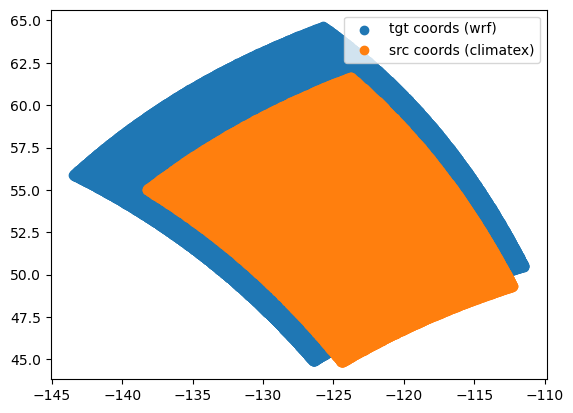


src:
 - min:  44.81489
 - max:  61.66336
 - shape:  (129078, 2)

tgt:
 - min:  44.87848
 - max:  64.64599
 - shape:  (275716, 2)


In [16]:
# sanity check plot
fig, ax = plt.subplots()
ax.scatter(x=tgt_coords[:,0], y=tgt_coords[:,1], label='tgt coords (wrf)')
ax.scatter(x=src_coords[:,0], y=src_coords[:,1], label='src coords (climatex)')
ax.legend(loc='upper right')
plt.show()

print('\nsrc:')
print(' - min: ', src_coords[:,1].min())
print(' - max: ', src_coords[:,1].max())
print(' - shape: ', src_coords.shape)

print('\ntgt:')
print(' - min: ', tgt_coords[:,1].min())
print(' - max: ', tgt_coords[:,1].max())
print(' - shape: ', tgt_coords.shape)

# CLIP TARGET DOMAIN

In [17]:
def clip_coords(src_coords, tgt_coords, tolerance=0.03):
    
    tree_src = cKDTree(src_coords)
    indices = tree_src.query_ball_point(tgt_coords, r=tolerance)
    tgt_mask = np.array([len(idx) > 0 for idx in indices])

    tree_tgt = cKDTree(tgt_coords)
    indices = tree_tgt.query_ball_point(src_coords, r=tolerance)
    src_mask = np.array([len(idx) > 0 for idx in indices])

    return tgt_mask, src_mask

In [18]:
def clip_stations(station_coords, src_coords, tgt_coords, tolerance=0.03):
    tree_src = cKDTree(src_coords)
    tree_tgt = cKDTree(tgt_coords)

    src_near = np.array([len(idx) > 0 for idx in tree_src.query_ball_point(station_coords, r=tolerance)])
    tgt_near = np.array([len(idx) > 0 for idx in tree_tgt.query_ball_point(station_coords, r=tolerance)])
    
    return src_near & tgt_near

44.81489

clipped src:
 - min:  45.528984
 - max:  61.663685
 - shape:  (186435, 2)


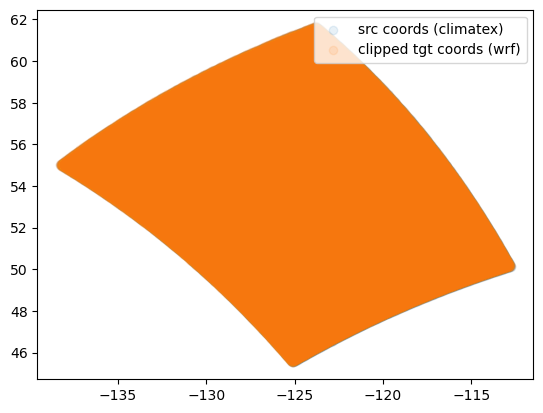

In [19]:
# clip tgt coords to climatex domain
print(src_coords[:,1].min())
tgt_mask, src_mask = clip_coords(src_coords, tgt_coords)

clipped_src_coords = src_coords[src_mask]
clipped_tgt_coords = tgt_coords[tgt_mask]

print('\nclipped src:')
print(' - min: ', clipped_tgt_coords[:,1].min())
print(' - max: ', clipped_tgt_coords[:,1].max())
print(' - shape: ', clipped_tgt_coords.shape)

fig, ax = plt.subplots()
ax.scatter(x=clipped_src_coords[:,0], y=clipped_src_coords[:,1], alpha=0.1, label='src coords (climatex)')
ax.scatter(x=clipped_tgt_coords[:,0], y=clipped_tgt_coords[:,1], alpha=0.1, label='clipped tgt coords (wrf)')
ax.legend(loc='upper right')
plt.show()


In [20]:
# stations_statistics["coords"] = list(
#     np.column_stack((stations_statistics["x"], stations_statistics["y"]))
# )
station_coords = stations_statistics[["x", "y"]].to_numpy()
mask = clip_stations(station_coords=station_coords, src_coords=src_coords, tgt_coords=tgt_coords)

clipped_stations = stations_statistics[mask].copy()
clipped_stations.to_csv('../data/eccc_data/clipped_stations_statistics.csv')
clipped_stations

,x,y,size_TEMP,size_PRECIP,size_WIND
STN_ID,,,,,
52,-123.439333,48.431972,1469,1454,1469
65,-123.529917,48.574917,1470,1418,0
96,-123.044745,48.783907,1463,1450,1463
114,-123.324776,48.413304,1474,1457,1474
138,-124.160278,49.350278,1475,1465,1475
...,...,...,...,...,...
55458,-123.008333,49.073333,1001,0,1020
55460,-122.630833,49.100833,1020,0,1019
55462,-122.713333,49.216111,1021,0,1021


/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection



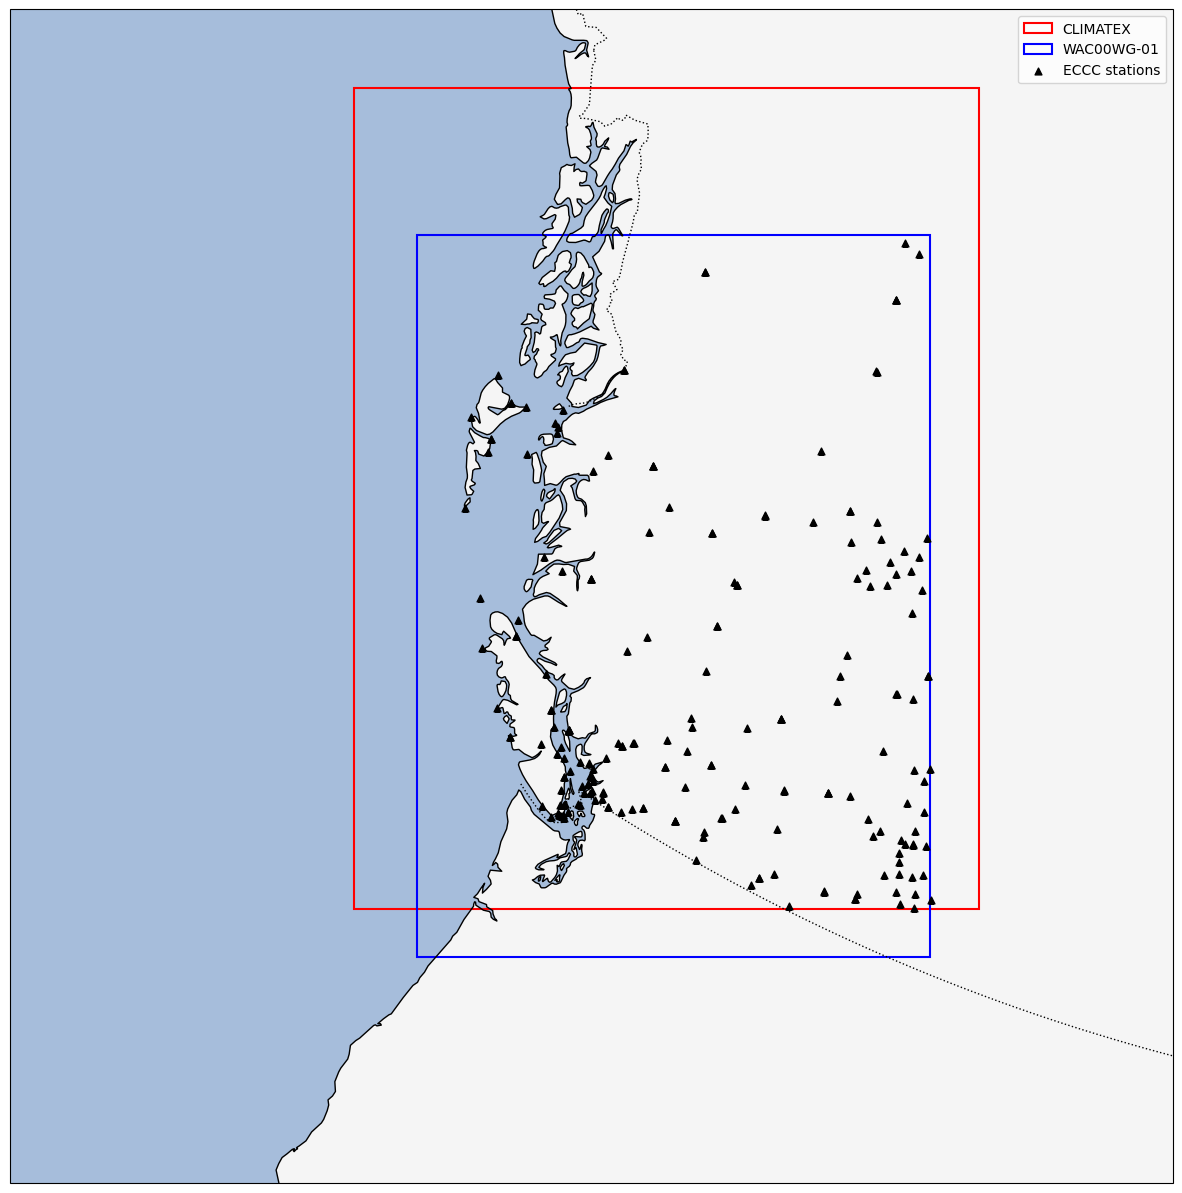

In [26]:
fig, ax = plt.subplots(figsize=(15,25), subplot_kw={'projection': projection})

with warnings.catch_warnings():
            # Ignore the nan warnings
            warnings.filterwarnings(
                "ignore",
                message="invalid value encountered in create_collection",
                category=RuntimeWarning,
            )

            # Add base map features
            ax.add_feature(cfeature.OCEAN, facecolor="#a6bddb", zorder=0)
            ax.add_feature(cfeature.LAND, facecolor="#f5f5f5", zorder=0)
            ax.add_feature(cfeature.COASTLINE, zorder=2)
            ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=2)

climatex_rect = get_rectangle(ax=ax, lons=climatex_ds.longitude, lats=climatex_ds.latitude, label='CLIMATEX', edgecol='red')
ax.add_patch(climatex_rect)

wac_rectangle = get_rectangle(ax=ax, lons=wrf_ds.XLONG.values.flatten(), lats=wrf_ds.XLAT.values.flatten(), label='WAC00WG-01', edgecol='blue')
ax.add_patch(wac_rectangle)

ax.scatter(x=clipped_stations.x, y=clipped_stations.y, marker='^', s=24, color='black', label='ECCC stations', transform=ccrs.PlateCarree())

ax.legend(loc='upper right')
ax.set_extent([wrf_ds.XLONG.min(), wrf_ds.XLONG.max(), wrf_ds.XLAT.min(), wrf_ds.XLAT.max()], crs=ccrs.PlateCarree())

plt.savefig('../reports/plots/observations/domains_w_stations.svg', dpi=600, format='svg', bbox_inches='tight')
plt.show()


# PERFORM INTERPOLATION
Use temperature as an example

In [22]:
def scipy_resampling(
    resampling: str,
    src_coords: np.array,
    tgt_coords: np.array,
    data: xr.DataArray | np.ndarray ,
):
    rbf_interpolator = RBFInterpolator(
        y=src_coords,
        d=data,
        kernel=resampling,
    )
    resampled_data = rbf_interpolator(tgt_coords)

    return resampled_data

In [23]:
data_tgt = climatex_ds['2t'].sel(lead_time=0, initial_date='2023-01-01T12:00:00.000000000')[tgt_mask]
data_src = wrf_ds['2t'].sel(XTIME='2023-04-04T06:00:00.000000000').values.flatten()[src_mask]

print(f" - src: {clipped_src_coords.shape}")    
print(f" - tgt: {clipped_tgt_coords.shape}")    # climatex
print(f" - data src: {data_src.shape}")
print(f" - data tgt: {data_tgt.values.shape}")

KeyError: "not all values found in index 'XTIME'. Try setting the `method` keyword argument (example: method='nearest')."

In [ ]:
wrf_ds.XTIME

<xarray.DataArray 'XTIME' (XTIME: 14)> Size: 112B
array(['2023-04-04T06:00:00.000000000', '2023-04-04T12:00:00.000000000',
       '2023-04-04T18:00:00.000000000', '2023-04-05T00:00:00.000000000',
       '2023-04-05T06:00:00.000000000', '2023-04-05T12:00:00.000000000',
       '2023-04-05T18:00:00.000000000', '2023-04-06T00:00:00.000000000',
       '2023-04-06T06:00:00.000000000', '2023-04-06T12:00:00.000000000',
       '2023-04-06T18:00:00.000000000', '2023-04-07T00:00:00.000000000',
       '2023-04-07T06:00:00.000000000', '2023-04-07T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 112B 2023-04-04T06:00:00 ... 2023-04-07T1...
Attributes:
    standard_name:  time
    axis:           T

In [ ]:
data = climatex_ds['2t'].sel(lead_time=0, initial_date='2023-01-01T12:00:00.000000000')[tgt_mask]
print('linear resampling')
resampled_data_linear = scipy_resampling(resampling="linear", src_coords=clipped_src_coords, tgt_coords=clipped_tgt_coords, data=data_src)
print('Cubic resampling')
resampled_data_cubic = scipy_resampling(resampling="cubic", src_coords=clipped_src_coords, tgt_coords=clipped_tgt_coords, data=data_src)

linear resampling


: 

In [ ]:
# sanity check : plot resampling

fig, ax = plt.subplots(1,3,figsize=(20,10), subplot_kw={'projection': projection})
ax = ax.ravel()

# ORIGINAL CLIMATEX COORDS
ax[0].scatter(x=src_coords[:,0], y=src_coords[:,1], c=data.values, transform=ccrs.PlateCarree())
ax[0].set_title(f"Variable 2t - original CLIMATEX coordinates")

# RESAMPLED LINEAR
ax[1].scatter(x=clipped_tgt_coords[:,0], y=clipped_tgt_coords[:,1], c=resampled_data_linear.values, transform=ccrs.PlateCarree())
ax[1].set_title(f"Variable 2t - linear resampling")

# RESAMPLED CUBIC
ax[2].scatter(x=clipped_tgt_coords[:,0], y=clipped_tgt_coords[:,1], c=resampled_data_cubic.values, transform=ccrs.PlateCarree())
ax[2].set_title(f"Variable 2t - cubic resampling")

plt.show()